In [1]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
import cv2

from scipy import ndimage, fft

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

2025-09-03 12:54:06.769708: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-03 12:54:06.904540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756918446.959425  168859 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756918446.975914  168859 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756918447.083913  168859 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

#### Experiment #1 : HandCrafted AntiSymmetric Bipolar Convolution


In [2]:
k =  3 # Top 10% highest l2-magnitude filters

In [3]:
t = np.zeros((1,2))
t[0,1] = np.sqrt(0.75)
print(fft.idctn(t, norm="ortho"), (k,k,1,1))
tf.math.reduce_euclidean_norm(fft.idctn(t, norm=None))


[[ 0.61237244 -0.61237244]] (3, 3, 1, 1)


2025-09-03 12:54:09.733058: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2025-09-03 12:54:09.733092: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-09-03 12:54:09.733096: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: tech-Alienware-m15-R6
2025-09-03 12:54:09.733100: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: tech-Alienware-m15-R6
2025-09-03 12:54:09.733246: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version is: 535.230.2
2025-09-03 12:54:09.733265: I external/local_xla/

<tf.Tensor: shape=(), dtype=float64, numpy=0.21650635094610965>

In [4]:
t = np.zeros((1,2))
t[0, 0] = np.sqrt(0.25)
print(fft.idctn(t, norm="ortho"), (k,k,1,1))

tf.math.reduce_euclidean_norm(fft.idctn(t, norm=None))


[[0.35355339 0.35355339]] (3, 3, 1, 1)


<tf.Tensor: shape=(), dtype=float64, numpy=0.08838834764831845>

In [5]:
0.61237244/2

0.30618622

In [6]:
filters = np.zeros((k,k,1,1))

F = 0
k = 2
filters = np.zeros((3,3,1,1))

t = np.zeros((k,k))
t[1,0] = np.sqrt(1)
t[0, 0] = np.sqrt(0)
#filters[0:2,1: ,0,0] = fft.idctn(t, norm="ortho")
filters[1:,0:2 ,0,0] = fft.idctn(t, norm="ortho")

filters[:,:,0,0]

array([[ 0. ,  0. ,  0. ],
       [ 0.5,  0.5,  0. ],
       [-0.5, -0.5,  0. ]])

In [7]:
F = 0
k = 2
b2 =0.25
t = np.zeros((k,k))
t[0,1] = np.sqrt(b2)
t[0, 0] = np.sqrt(1-b2)















In [8]:
#var = 2/(128*9)

img = np.zeros((355,355)) # cv2.imread('input4.png', 0)/255. 
mid = img.shape[0]//2
img[mid, mid] = 1.
#img = (img-np.mean(img))/np.std(img)
#img = tf.repeat(tf.expand_dims([img], axis=-1) , repeats = 512, axis=-1)  #get_double_slit(shape) , axis=0)
print(img.shape)

(355, 355)


(3, 3, 1, 1)
0
0 [[0.        0.        0.       ]
 [0.6830127 0.1830127 0.       ]
 [0.6830127 0.1830127 0.       ]]
1
1 [[0.        0.6830127 0.1830127]
 [0.        0.6830127 0.1830127]
 [0.        0.        0.       ]]
2
2 [[0.        0.        0.       ]
 [0.6830127 0.1830127 0.       ]
 [0.6830127 0.1830127 0.       ]]
3
3 [[0.        0.6830127 0.1830127]
 [0.        0.6830127 0.1830127]
 [0.        0.        0.       ]]
4
4 [[0.        0.        0.       ]
 [0.6830127 0.1830127 0.       ]
 [0.6830127 0.1830127 0.       ]]
5
5 [[0.        0.6830127 0.1830127]
 [0.        0.6830127 0.1830127]
 [0.        0.        0.       ]]
6
6 [[0.        0.        0.       ]
 [0.6830127 0.1830127 0.       ]
 [0.6830127 0.1830127 0.       ]]
7
7 [[0.        0.6830127 0.1830127]
 [0.        0.6830127 0.1830127]
 [0.        0.        0.       ]]
8
8 [[0.        0.        0.       ]
 [0.6830127 0.1830127 0.       ]
 [0.6830127 0.1830127 0.       ]]
9
9 [[0.        0.6830127 0.1830127]
 [0.        0.

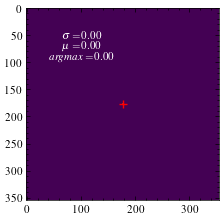

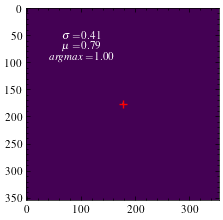

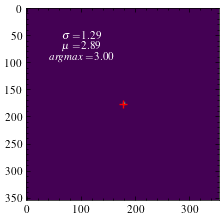

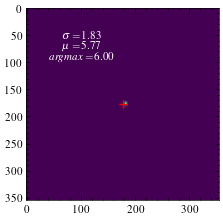

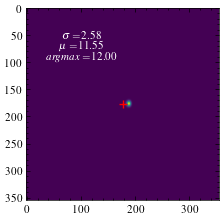

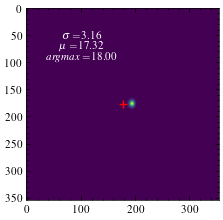

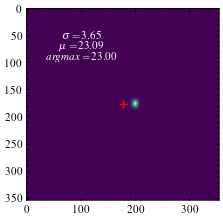

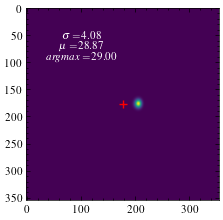

In [ ]:
import matplotlib.patches as mpatches

w =tf.cast(filters, dtype=tf.float32)# tf.expand_dims(filters, -1), dtype=tf.float32)
w = tf.transpose(w, perm=(1,0,2,3))
print(w.shape)

x = img


directory = f"figures/prop_unipolar_0.25"
if not os.path.exists(directory):
	os.makedirs(directory)
x = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = filters.shape[-2], axis=-1), dtype=tf.float32) 
for i in range(101):
	print(i)
	if i in [0,1, 10, 20, 40, 60, 80, 100]:
		fig, ax = plt.subplots()
		#print(x.shape)
		x = x/np.std(x)
		vals = x[0, x.shape[1]//2, :, :]
		vals = vals/np.sum(vals)

		#print("VALS", np.sum(vals))
		pos = np.expand_dims(np.linspace(-(x.shape[1]//2), x.shape[1]//2, x.shape[1]),-1)
		mean = tf.reduce_sum(pos*vals)
		var = tf.reduce_sum(((pos-mean)**2) * vals)
		std = np.sqrt(var)
		#print(mean, np.sqrt(var))
		
		#x = tf.repeat(x , repeats = filters.shape[-2], axis=-1)
		#print(x.shape)

		im = ax.imshow(np.sum(x[0,:,:,:], axis=-1))
		ax.plot(mid, mid, marker = '+', color='red')

		#ax.plot(112+mean, 112, marker = ".", color='black')
		arr =  mpatches.FancyArrowPatch((mid+mean, mid), (mid+mean+std, mid),
								mutation_scale=4, shrinkA=0, shrinkB=0,zorder=10, color="red")
		#ax.add_patch(arr)
		
		ax.annotate(r'$\sigma=$'+f"{std:.2f}", (100, 60), ha='center', va='bottom',color='white')
		ax.annotate(r'$\mu=$'+f"{mean:.2f}", (100, 80), ha='center', va='bottom',color='white')
		ax.annotate(r'$argmax=$'+f"{np.argmax(vals)-mid:.2f}", (100, 100), ha='center', va='bottom',color='white')

		#ax.annotate(r'$\sigma=$'+f"{std:.2f}", (.5, 6), xycoords=arr, ha='center', va='bottom',color='white')
		#ax.arrow(, 112, dx=, dy= 0, color='black')

		#ax.set(xlim=( (mid-(5)-1), (mid+(10)+1)), ylim=((mid-(5)-1), (mid+(5)+1)))
		#ax.set_xticks(np.linspace(-round(std)-1, round(std)+1, int(0.5*(std)+3)))
		#fig.colorbar(im, orientation='vertical')
		fig.savefig(directory + f'/{i}.pdf', dpi=150,  transparent=True, bbox_inches='tight')


	w = np.zeros((3,3,1,1))

	if i%2 == 0:
		w[1:,0:2 ,0,0] = fft.idctn(t, norm="ortho")
	else:
		w[0:2,1: ,0,0] = fft.idctn(t, norm="ortho")

	print(i, w[:,:,0,0])

	x = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
							padding='SAME') )